## Schedule Selector
Simulates four types of schedules, strong, medium-strong, medium-weak, and weak, about 19000 times and then pulls the RPIs from each schedule and plots them into a box plot

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from scipy import stats
%matplotlib inline

In [2]:
df = pd.read_excel('full_Raw_Data.xlsx')

In [3]:
def rpi_ranker(df):
    '''
    Purpose: add rankings to each year from 2014-2016
    
    df: dataframe object that needs to be split then ranked by year 
    '''
    # Group the data frame by year
    year = df.groupby('Year')
    df_4 = year.get_group(2014)
    df_5 = year.get_group(2015)
    df_6 = year.get_group(2016)
    
    # add to array to prepare for looping
    years = [df_4,df_5,df_6]
    
    # set open list, loop through years
    df_rankings = []
    for df in years:
    # Replace null values with numpy
        tournament = df['Tournament']
        tournament = tournament.fillna(0)
        df['Tournament'] = tournament
    
    # Set a numpy array equal to the length of the dataframe
        rpi_rank = np.arange(1,len(df['Tournament'])+1)
    
    # create and set rpi_rank equal to the 'RPI RANK' dataframe column
        df['RPI RANK'] = rpi_rank
        df_rankings.append(df)
    
    df_ranked = pd.concat([df for df in df_rankings], axis=0)
    #return the updated data frame value 
    return df_ranked

In [4]:
df_ranked = rpi_ranker(df)

/Users/danielbillmann/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/danielbillmann/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:
top_40_opp_sos = df_ranked[(df_ranked['RPI RANK']<=40)]['Opp SOS'].mean()
top_40_sos = df_ranked[(df_ranked['RPI RANK']<=40)]['SOS'].mean()
top_40_wp = df_ranked[(df_ranked['RPI RANK']<=40)]['WIN %'].mean()


top_80_opp_sos = df_ranked[(df_ranked['RPI RANK']>40) & (df_ranked['RPI RANK']<=80)]['Opp SOS'].mean()
top_80_sos = df_ranked[(df_ranked['RPI RANK']>40) & (df_ranked['RPI RANK']<=80)]['SOS'].mean()
top_80_wp = df_ranked[(df_ranked['RPI RANK']>40) & (df_ranked['RPI RANK']<=80)]['WIN %'].mean()

top_120_opp_sos = df_ranked[(df_ranked['RPI RANK']>80) & (df_ranked['RPI RANK']<=120)]['Opp SOS'].mean()
top_120_sos = df_ranked[(df_ranked['RPI RANK']>80) & (df_ranked['RPI RANK']<=120)]['SOS'].mean()
top_120_wp = df_ranked[(df_ranked['RPI RANK']>80) & (df_ranked['RPI RANK']<=120)]['WIN %'].mean()

top_200_opp_sos = df_ranked[(df_ranked['RPI RANK']>120) & (df_ranked['RPI RANK']<=200)]['Opp SOS'].mean()
top_200_sos = df_ranked[(df_ranked['RPI RANK']>120) & (df_ranked['RPI RANK']<=200)]['SOS'].mean()
top_200_wp = df_ranked[(df_ranked['RPI RANK']>120) & (df_ranked['RPI RANK']<=200)]['WIN %'].mean()

In [7]:
new_groupings = pd.DataFrame(data=[
        ['Top 40',top_40_wp,top_40_sos,top_40_opp_sos],
        ['Top 80',top_80_wp,top_80_sos,top_80_opp_sos],['Top 120',top_120_wp,top_120_sos,top_120_opp_sos],
        ['Top 200',top_200_wp,top_200_sos,top_200_opp_sos]],
            columns=['Team','WP','SOS','OPP SOS'])

In [9]:
new_groupings[(new_groupings['Team']=='Top 40')]

,Team,WP,SOS,OPP SOS
0,Top 40,0.729147,0.593709,0.559943


In [136]:
def build_levers():
    sched_titles = ['Top 40','Top 80','Top 120','Top 200']
    home_probs = [[.25,.25,.5],[.45,.3,.25],[.6,.2,.2],[.75,.15,.1]]
    away_probs = [[.15,.2,.65],[.3,.3,.4],[.45,.25,.3],[.65,.15,.2]]
    levers = []
    for i in range(0,len(sched_titles)):
        levers.append([sched_titles[i],home_probs[i],away_probs[i]])
    df_levers = pd.DataFrame(levers,columns=['Team','Home_Probs','Away_Probs'])
    return df_levers

In [137]:
df_levers = build_levers()
df_levers

,Team,Home_Probs,Away_Probs
0,Top 40,"[0.25, 0.25, 0.5]","[0.15, 0.2, 0.65]"
1,Top 80,"[0.45, 0.3, 0.25]","[0.3, 0.3, 0.4]"
2,Top 120,"[0.6, 0.2, 0.2]","[0.45, 0.25, 0.3]"
3,Top 200,"[0.75, 0.15, 0.1]","[0.65, 0.15, 0.2]"


In [138]:
def non_conf_result_probs(group,probabilities,location):
    '''
    function that takes two arguments, group and probabilities
    group: is the group that the team fits into (Top 20,40, etc)
    probabilities: the probability of winning, drawing, or losing to the group mentioned
    location: where the game is being played
    the function returns the likelihood of each result against each team as well as the result as an array
    '''
    schedule_weighted_probs = []
    outcome = []
    count = 0
    for i,j,k in zip(group,probabilities,location):
        opt = ['W','D','L']
        name = i
        wp = j[0]
        dp = j[1]
        lp = j[2]
        z = np.random.choice(opt,10000, p=[wp,dp,lp])
        w = (np.count_nonzero(z=='W'))/10000
        d = (np.count_nonzero(z=='D'))/10000
        l = (np.count_nonzero(z=='L'))/10000
        outcome.append(np.random.choice(opt,1,p=[w,d,l]))
        schedule_weighted_probs.append([name,w,d,l,str(outcome[count][0]),k])
        count +=1
        n_c_r = pd.DataFrame(schedule_weighted_probs,columns=["Team","Win_Prob","Draw_Prob","Loss_Prob","Result","Location"])
    return n_c_r

In [139]:
def add_team_profiles(nonconference_schedule):
    '''
    takes nonconference_schedule and matches the winning percentage and strength of schedule based on the team type
    '''
    wp = []
    sos = []
    for i in nonconference_schedule.Team: 
        for j,k,l in zip(new_groupings.Team,new_groupings.WP,new_groupings.SOS):
            if i in j:
                wp.append(k)
                sos.append(l)
    nonconference_schedule['WP'] = wp
    nonconference_schedule['SOS'] = sos
    return nonconference_schedule

In [140]:
conf_schedule_probs = [
 ['SMU', 0.4, 0.2, 0.4],
 ['Houston', 0.6, 0.25, 0.15],
 ['UConn', 0.5, 0.25, 0.25],
 ['Temple', 0.6, 0.2, 0.2],
 ['UCF', 0.65, 0.2, 0.15],
 ['South Fla.', 0.55, 0.25, 0.2],
 ['Tulsa', 0.63, 0.23, 0.14],
 ['Memphis', 0.4, 0.3, 0.3],
 ['East Carolina', 0.8, 0.15, 0.05]]

In [141]:
#conf_schedule_probs = [
# ['SMU', 0.4, 0.2, 0.4],
# ['Houston', 0.6, 0.25, 0.15],
# ['UConn', 0.5, 0.25, 0.25],
# ['Temple', 0.6, 0.2, 0.2],
# ['UCF', 0.65, 0.2, 0.15],
# ['South Fla.', 0.55, 0.25, 0.2],
# ['Tulsa', 0.63, 0.23, 0.14],
# ['Memphis', 0.4, 0.3, 0.3],
# ['East Carolina', 0.8, 0.15, 0.05]]

In [142]:
def conf_result_probs(conf_schedule_probs):
    '''
    function that takes list "first_schedule_probs" as its argument
    each probability item in first_schedule_probs will be used to make simulation of probabilities for each team
    
    the function returns the likelihood of each result against each team as well as the result as an array
    '''
    schedule_weighted_probs = []
    outcome = []
    count = 0
    for i in conf_schedule_probs:
        opt = ['W','D','L']
        name = i[0]
        wp = i[1]
        dp = i[2]
        lp = i[3]
        z = np.random.choice(opt,10000, p=[wp,dp,lp])
        w = (np.count_nonzero(z=='W'))/10000
        d = (np.count_nonzero(z=='D'))/10000
        l = (np.count_nonzero(z=='L'))/10000
        outcome.append(np.random.choice(opt,1,p=[w,d,l]))
        schedule_weighted_probs.append([name,w,d,l,str(outcome[count][0])])
        count +=1
    return schedule_weighted_probs

In [143]:
conf_results = conf_result_probs(conf_schedule_probs)

In [144]:
conf_schedule = pd.DataFrame(data=conf_results,columns=["Team","Win_Prob","Draw_Prob","Loss_Prob","Result"])

In [145]:
conf_schedule['WP'] = [.6364,.4688,.8478,.1520,.5263,.7105,.4474,.7250,.3056]
conf_schedule['SOS'] = [.5819,.4665,.5759,.5039,.5856,.4930,.5899,.5543,.5148]
conf_schedule['Location'] = ['A','A','A','A','H','H','H','H','H']

In [146]:
def final_season_calculations(full_schedule):
    """
    This is the final season calculations
    
    Inputs:
    full_schedule: a dataframe of what UC's schedule and season results might look like in the future. 
    
    Returns:
    cinci_2017_d: a single row data frame of UC's season results
    """
    season_sum = Counter(full_schedule["Result"])
    d = season_sum['D'] # draws
    l = season_sum['L'] # losses
    w = season_sum['W']# wins
    uc_wp = (w + (.5 * d))/(w + l + d)
    sos = full_schedule['WP'].mean()
    opp_sos = full_schedule['SOS'].mean()
    uc_2017_rpi = (.25 * uc_wp) + (.5 * sos) + (.25 * opp_sos)
    cinci_2017_d = ['Cincinnati 2017', 'AAC',w,l,d,uc_wp,sos,opp_sos,uc_2017_rpi,'2017-Based Future']
    cinci_2017_d = pd.DataFrame(data=[cinci_2017_d],columns=['Team','Conference','W','L','D', 'WIN_%','SOS','Opp_SOS','RPI','Year'])
    return cinci_2017_d

Strong schedule: while "a" (top 40) goes up, decrease b by 1, c by 2, and d by 2
Medium-strong schedule: while "b" (top 80) goes up, decrease a by 2, c by 1, and d by 2
Medium-weak schedule: while "c" (top 120) goes up, decrease a by 2, b by 1, and d by 2
weak schedule: while "d" (top 80) goes up, decrease a by 2, b by 2, and c by 1

In [147]:
# strong 
def strong_schedule():
    game = []
    a = 25
    b = 25
    c = 25
    d = 25

    for i in range(a,100,5):
        z = [a,b,c,d]
        game.append(z)
        b -= 1
        c -= 2
        d -= 2
        a = i+5
        if c<0:
            c=0
        if d<0:
            d=0
        if a+b+c+d>100:
            if c>0:
                c = 0
            if d>0:
                d = 0
            b = 100-a
    return game

In [148]:
# medium
# Medium-strong schedule: while "b" (top 80) goes up, decrease a by 2, c by 1, and d by 2
def medium_strong():
    game = []
    a = 25
    b = 25
    c = 25
    d = 25
    for i in range(b,100,5):
        z = [a,b,c,d]
        game.append(z)
        b = i+5
        c -= 1
        d -= 2
        a -= 2
        if a<0:
            a=0
        if d<0:
            d=0
        if a+b+c+d>100:
            if a>0:
                a = 0
            if d>0:
                d = 0
            c = 100-b
    return game
    

In [149]:
# medium
# Medium-weak schedule: while "c" (top 120) goes up, decrease a by 2, b by 1, and d by 2
def medium_weak():
    game=[]
    a = 25
    b = 25
    c = 25
    d = 25
    for i in range(c,100,5):
        z = [a,b,c,d]
        game.append(z)
        b -= 1
        c = i+5
        d -= 2
        a -= 2
        if a<0:
            a=0
            break
        if d<0:
            d=0
            break
        if a+b+c+d>100:
            if a>0:
                a = 0
                break
            if d>0:
                d = 0
                break
            b= 100-c
    return game

In [150]:
def weak_schedule():
    game = []
    a=25
    b=25
    c=25
    d=25
    for i in range(d,100,5):
        z = [a,b,c,d]
        game.append(z)
        b -= 2
        c -= 1
        d = i+5
        a -= 2
        if a<0:
            a=0
            break
        if b<0:
            b=0
            break
        if a+b+c+d>100:
            if a>0:
                a = 0
                break
            if b>0:
                b = 0
                break
            c= 100-d
    return game

In [151]:
def schedule_game(t4,t8,t12,t20):
    choices = ["Top 40","Top 80","Top 120","Top 200"]
    c = np.random.choice(choices,1,p=[t4,t8,t12,t20])
    c = c[0]
    return c

In [152]:
def home_away(arr_sched):
    '''
    takes input arr_schedule, which is a string array of types of teams that and outputs an array of "home" or "away"
    '''
    location = []
    for c in arr_sched:
        if c == "Top 40":
            b = np.random.choice(["H","A"],1,p=[.2,.8])
        elif c == "Top 80":
            b = np.random.choice(["H","A"],1,p=[.5,.5])
        elif c == "Top 120":
            b = np.random.choice(["H","A"],1,p=[.7,.3])
        else:
            b = np.random.choice(["H","A"],1,p=[.8,.2])
        location.append(b[0])
    return location

In [153]:
def build_schedule(w,x,y,z,matches):
    '''
    Takes three arguments, team_type, venue, and matches and outputs a schedule
    team_type: string argument, the output of schedule_game()
    venue: string argument, the output of home_away()
    matches: integer input, number of matches being played
    '''
    random_select_sched = []
    for i in range(0,matches):
        a = schedule_game(w,x,y,z)
        b = home_away(a)[0]
#        print(home_away(a)[0])
        for i,j,k, in zip(df_levers.Team,df_levers.Home_Probs,df_levers.Away_Probs):
            if a == i:
                if b == 'H':
                    random_select_sched.append([i,j,'Home'])
                if b == 'A':
                    random_select_sched.append([i,k,'Away'])
    
    schedule = pd.DataFrame(data=random_select_sched,columns=["Team","Probs","Location"])
    return schedule


In [154]:
# arrays that build_auto_schedule will append final RPIs to, which then will be the basis of analysis
w_schedule_rpi = []
mw_schedule_rpi = []
ms_schedule_rpi = []
s_schedule_rpi = []

In [155]:
def build_auto_schedule(stype):
    """
    takes a schedule type (st) as its only argument
    schedule type can be "ss" - strong schedule, "ms" - medium strong, "mw" - medium weak, "ws" - weak schedule
    """
    if stype.lower() in "ws":
        st = weak_schedule()
        title = "Weak Schedule" 
    elif stype.lower() in "mw":
        st = medium_weak()
        title = "Medium Weak Schedule"
    elif stype.lower() in "ms":
        st = medium_strong()    
        title = "Medium Strong Schedule"
    else:
        st = strong_schedule()
        title = "Strong Schedule"
    s = []
    for i in st:
        s.append(build_schedule(float(i[0])/100,float(i[1])/100,float(i[2])/100,float(i[3])/100,10))
    ncrp = []
    for i in s:
        ncrp.append(non_conf_result_probs(i.Team,i.Probs,i.Location))
    atp = []
    for i in ncrp:
        atp.append(add_team_profiles(i))
    fs = []
    for i in atp:
        fs.append(pd.concat([i, conf_schedule],axis=0))
    fc = []
    for i in fs:
        fc.append(final_season_calculations(i))
    
    rpi = []
    for i in fc:
        rpi.append(i['RPI'])
    
    f_rpi = []
    for i in rpi:
        f_rpi.append(i[0])
    
    if stype.lower() in "ws":
        w_schedule_rpi.append(f_rpi)
    elif stype.lower() in "mw":
        mw_schedule_rpi.append(f_rpi)
    elif stype.lower() in "ms":
        ms_schedule_rpi.append(f_rpi)
    else:
        s_schedule_rpi.append(f_rpi)
    return f_rpi

In [156]:
w_rpis=[]
mw_rpis=[]
ms_rpis=[]
s_rpis=[]

w_schedule_rpi=[]
mw_schedule_rpi=[]
ms_schedule_rpi=[]
s_schedule_rpi=[]

In [157]:
x = 15
y = 13
# z = how many observations do you want?
z = int(input("How many observations do you want? Please use an integer: "))
yy = round(z/x)
xx = round(z/y)
print(xx,yy)

How many observations do you want? Please use an integer: 19500
1500 1300


In [158]:
for _ in range(0,xx):
    build_auto_schedule("ws")
    build_auto_schedule("mw")
    print(if _/1000)

In [159]:
for _ in range(0,yy):
    build_auto_schedule("ms")
    build_auto_schedule("ss")

In [160]:
print(len(w_schedule_rpi),len(mw_schedule_rpi),len(ms_schedule_rpi),len(s_schedule_rpi),"\n",len(w_rpis),len(mw_rpis),
len(ms_rpis),len(s_rpis))

1500 1500 1300 1300 
 0 0 0 0


In [161]:
for a in w_schedule_rpi:
    for j in a:
        w_rpis.append(j)

In [162]:
for b in mw_schedule_rpi:
    for k in b:
        mw_rpis.append(k)

In [163]:
for c in ms_schedule_rpi:
    for l in c:
        ms_rpis.append(l)

In [164]:
for d in s_schedule_rpi:
    for m in d:
        s_rpis.append(m)

In [165]:
print(len(w_rpis),
len(mw_rpis),
len(ms_rpis),
len(s_rpis))

19500 19500 19500 19500


In [166]:
w = np.array(w_rpis)
mw = np.array(mw_rpis)
ms = np.array(ms_rpis)
s = np.array(s_rpis)

In [167]:
w_list = w.tolist()
w_list.sort()
mw_list = mw.tolist()
mw_list.sort()
ms_list = ms.tolist()
ms_list.sort()
s_list = s.tolist()
s_list.sort()

In [104]:
intervals = [[min(w_list),w_list[round(len(w_list)*.25)],w_list[round((len(w_list)*.5))],w_list[round(len(w_list)*.75)],max(w_list)],
[min(mw_list),mw_list[round(len(mw_list)*.25)],mw_list[round((len(mw_list)*.5))],mw_list[round(len(mw_list)*.75)],max(mw_list)],
[min(ms_list),ms_list[round(len(ms_list)*.25)],ms_list[round((len(ms_list)*.5))],ms_list[round(len(ms_list)*.75)],max(ms_list)],
[min(s_list),s_list[round(len(s_list)*.25)],s_list[round((len(s_list)*.5))],s_list[round(len(s_list)*.75)],max(s_list)]]

pd_intervals = pd.DataFrame(intervals,index=['Weak','Medium-Weak','Medium-Strong','Strong'],columns=['Minimum','25%','Median','75%','Max'])
pd_intervals

,Minimum,25%,Median,75%,Max
Weak,0.500147,0.560077,0.571175,0.581430,0.626340
Medium-Weak,0.504542,0.562101,0.573540,0.584435,0.631165
Medium-Strong,0.503567,0.562440,0.574347,0.585517,0.631401
Strong,0.513079,0.565242,0.575941,0.587710,0.638390


# Confidence Intervals

In [105]:
# Confidence Intervals
np_w_list = np.array(w_list)
np_mw_list = np.array(mw_list)
np_ms_list = np.array(ms_list)
np_s_list = np.array(s_list)
N = len(s_rpis)

In [106]:
conf_int_list = [[np_w_list.mean(), np_w_list.std()],
[np_mw_list.mean(), np_mw_list.std()],
[np_ms_list.mean(), np_ms_list.std()],
[np_s_list.mean(), np_s_list.std()]]

In [107]:
conf_intervals = []
for i in conf_int_list:
    conf_intervals.append([stats.norm.interval(0.95, loc=i[0], scale=i[1]/sqrt(N))])

In [108]:
pd_intervals['Mean'] = [i[0] for i in conf_int_list]
pd_intervals['StD'] = [i[1] for i in conf_int_list]

In [109]:
pd_intervals["2.5 Interval"] = [i[0][0] for i in conf_intervals]
pd_intervals["97.5 Interval"] = [i[0][1] for i in conf_intervals]

In [110]:
pd_intervals

,Minimum,25%,Median,75%,Max,Mean,StD,2.5 Interval,97.5 Interval
Weak,0.500147,0.560077,0.571175,0.581430,0.626340,0.570542,0.015832,0.570339,0.570745
Medium-Weak,0.504542,0.562101,0.573540,0.584435,0.631165,0.573052,0.016648,0.572839,0.573266
Medium-Strong,0.503567,0.562440,0.574347,0.585517,0.631401,0.574020,0.016885,0.573804,0.574237
Strong,0.513079,0.565242,0.575941,0.587710,0.638390,0.576309,0.016878,0.576093,0.576526


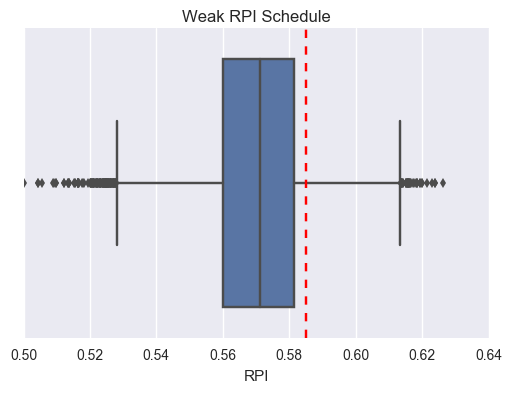

In [111]:
sns.boxplot(w_list)
plt.xlabel("RPI")
plt.title("Weak RPI Schedule")
plt.axvline(.585, color='r', linestyle='dashed')

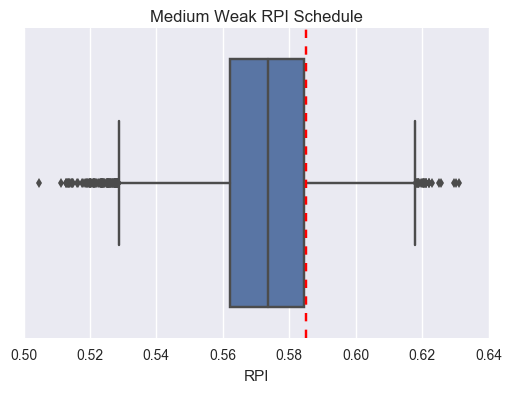

In [112]:
sns.boxplot(mw_list)
plt.xlabel("RPI")
plt.title("Medium Weak RPI Schedule")
plt.axvline(.585, color='r', linestyle='dashed')

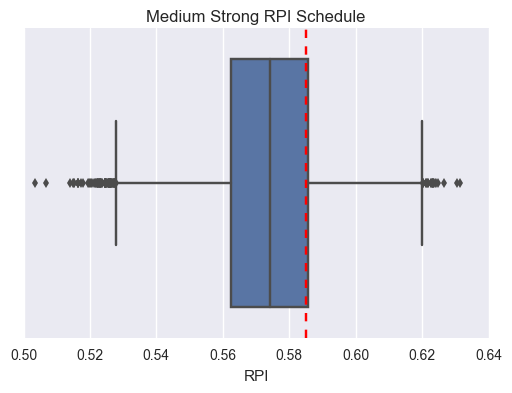

In [113]:
sns.boxplot(ms_list)
plt.xlabel("RPI")
plt.title("Medium Strong RPI Schedule")
plt.axvline(.585, color='r', linestyle='dashed')

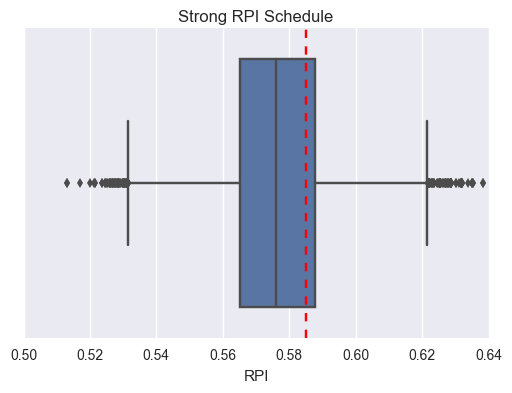

In [114]:
sns.boxplot(s_list)
plt.xlabel("RPI")
plt.title("Strong RPI Schedule")
plt.axvline(.585, color='r', linestyle='dashed')

In [1]:
#df_ranked[((df_ranked['Year']==2016) & (df_ranked['RPI RANK'] >41) & (df_ranked['RPI RANK']<=81) &( df_ranked['Team']!='Cincinnati') & (df_ranked['Tournament']==0))]['Teams']